In [601]:
# import libraries
from scipy import stats
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
import numpy as np
import pandas as pd
import pandas_ta as ta
import xgboost as xgb
import yfinance as yf
#
import warnings
warnings.filterwarnings('ignore')

In [602]:
# utils

def calc_sma(df: pd.DataFrame, length: int):
    df[f'SMA_{length}'] = df['Adj Close'].rolling(window=length).mean()
    df[f'SMA_{length}'] = (df[f'SMA_{length}']-df['Adj Close'])/df['Adj Close']
    return df[f'SMA_{length}']

def corr_ind_ret(df: pd.DataFrame, indi: str):
    # Compute correlation between SMA and daily returns
    corr = np.corrcoef(df[indi].values, df['Return'].values)[0, 1]
    # Print correlation coefficient
    print(f"Correlation coefficient between {indi} and daily returns: ", corr)

    # Plot scatter plot with linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[indi], df['Return'])
    line = slope * df[indi] + intercept
    plt.scatter(df[indi], df['Return'])
    plt.plot(df[indi], line, color='red')
    plt.xlabel(indi)
    plt.ylabel('Daily Returns')
    plt.title(f'{indi} vs Daily Returns')
    plt.show()

# functions for model performance evaluation
def MAE(y_true, y_hat):
    return np.mean(np.abs(y_true - y_hat))

def MSE(y_true, y_hat):
    return np.mean(np.square(y_true - y_hat))

def RMSE(y_true, y_hat):
    return np.sqrt(MSE(y_true, y_hat))

In [603]:
# Load historical data
ticker = 'MSFT'
df = yf.download(ticker)
df = df.iloc[1:]
# df = df['Adj Close']

# Calculate SMAs
sma_windows = [7, 20, 50]
for sma_window in sma_windows:
    df[f'SMA_{sma_window}'] = calc_sma(df, sma_window)
# Calculate RSI with a 14-day window using pandas_ta library
df.ta.rsi(length=14, append=True)

df.ta.adx(length=14, append=True)

# Compute daily returns
df['Return'] = df['Adj Close'].pct_change().shift(-1)
df['Return_L1'] = df['Return'].shift(1)
# df['Return_L1'] = df['Return']

df = df.dropna()

[*********************100%***********************]  1 of 1 completed


In [604]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_7,SMA_20,SMA_50,RSI_14,ADX_14,DMP_14,DMN_14,Return,Return_L1
Date,,,,,,,,,,,,,,,
1986-05-23,0.107639,0.109375,0.107639,0.107639,0.067156,4089600,0.016128,0.029434,-0.036856,48.300429,20.435061,29.994786,21.436306,0.032256,0.000000
1986-05-27,0.107639,0.111111,0.107639,0.111111,0.069322,13881600,-0.015624,-0.005859,-0.065077,57.932751,20.730186,31.880716,19.415464,0.031248,0.032256
1986-05-28,0.111111,0.114583,0.111111,0.114583,0.071488,15523200,-0.042205,-0.035983,-0.091286,64.962796,21.951650,38.159035,17.626008,0.022735,0.031248
1986-05-29,0.114583,0.118924,0.113715,0.117188,0.073113,45676800,-0.055030,-0.055190,-0.108523,69.131001,23.944929,44.014582,15.341465,0.037034,0.022735
1986-05-30,0.118056,0.123264,0.118056,0.121528,0.075821,27072000,-0.074491,-0.084288,-0.136502,74.560864,26.417575,47.853027,13.193388,-0.028569,0.037034


In [605]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_7,SMA_20,SMA_50,RSI_14,ADX_14,DMP_14,DMN_14,Return,Return_L1
Date,,,,,,,,,,,,,,,
2023-03-28,275.790009,276.140015,272.049988,275.230011,275.230011,21878600,0.000794,-0.040399,-0.065258,60.380827,25.394918,33.364081,18.113708,0.019184,-0.004161
2023-03-29,278.959991,281.140015,278.410004,280.510010,280.510010,25087000,-0.013827,-0.052358,-0.079946,64.212886,26.190891,36.549298,16.987673,0.012620,0.019184
2023-03-30,284.230011,284.459991,281.480011,284.049988,284.049988,25053400,-0.020952,-0.058370,-0.087974,66.548966,27.227532,38.583672,16.260126,0.014962,0.012620
2023-03-31,283.730011,289.269989,283.000000,288.299988,288.299988,32740300,-0.027452,-0.066526,-0.097468,69.152449,28.583577,41.184880,15.150897,-0.003711,0.014962
2023-04-03,286.519989,288.269989,283.950012,287.230011,287.230011,24883300,-0.019069,-0.057764,-0.090791,67.723377,29.842762,39.187547,14.416127,-0.004456,-0.003711


Correlation coefficient between SMA_7 and daily returns:  0.0590270913948789


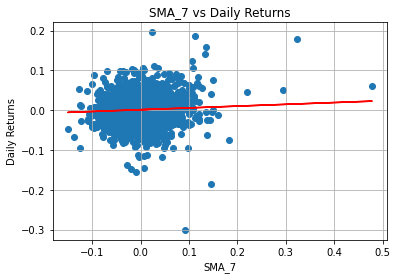

Correlation coefficient between SMA_20 and daily returns:  0.04357354232018691


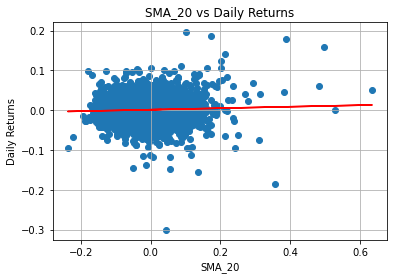

Correlation coefficient between SMA_50 and daily returns:  0.04148617130925285


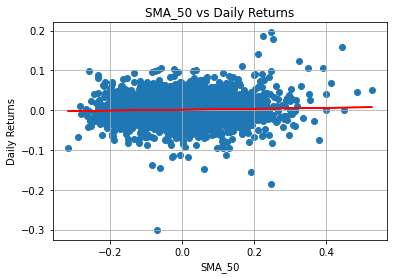

Correlation coefficient between RSI_14 and daily returns:  -0.024290679249687648


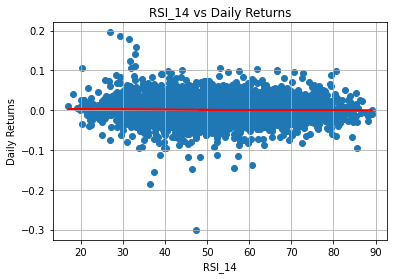

Correlation coefficient between ADX_14 and daily returns:  0.004583811233313984


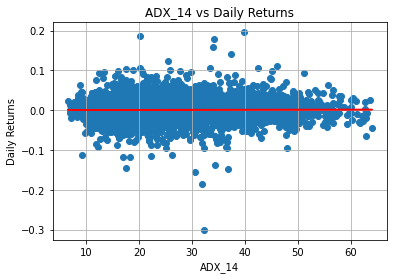

Correlation coefficient between DMP_14 and daily returns:  -0.00900467646794969


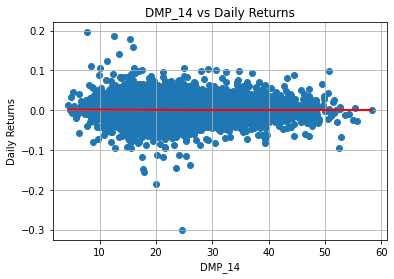

Correlation coefficient between Return_L1 and daily returns:  -0.020383503407254984


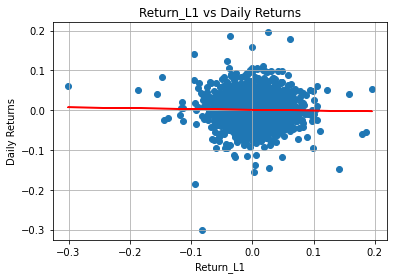

In [606]:
indicators = ["SMA_7", "SMA_20", "SMA_50", "RSI_14", "ADX_14", "DMP_14", "Return_L1"]

for indi in indicators:
    corr_ind_ret(df, indi)

# XGB Regression

## Indicators

In [607]:
# data preprocessing for regression

time_step = 1
train_split = 0.8
all_split = int(len(df) * train_split)
columns = indicators+['Return']
df = df[columns]
retL1_col = df.pop('Return_L1')
df.insert(len(df.columns), 'Return_L1', retL1_col)
ret_col = df.pop('Return')
df.insert(len(df.columns), 'Return', ret_col)
data = df.copy()
data = np.array(data.reset_index(drop=True))
# scale with training data only
train_set = scaler.fit_transform(data[:all_split])
# here val_set is the entire set, then later we only test on exclusive validation period
val_set = scaler.transform(data)
val_set = scaler.transform(data)

X_train, y_train = train_set[:,:-1][:all_split], train_set[:,-1][:all_split]
X_val, y_val = val_set[:,:-1], val_set[:,-1]

In [608]:
reg = xgb.XGBRegressor(objective='reg:squarederror')
reg.fit(np.squeeze(X_train), y_train, verbose=False)  # Change verbose to True if you want to see it train

# predicting response
y_hat = reg.predict(np.squeeze(X_val))
val_set[:,-1] = y_hat
y_hat = scaler.inverse_transform(val_set)[:,-1] # inverse transformation

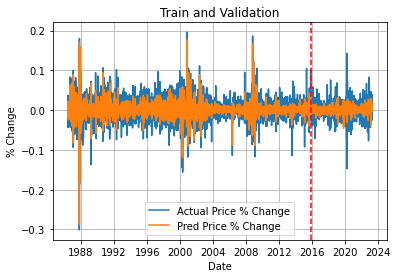

Validation Performance Metrics with Indicators ['SMA_7', 'SMA_20', 'SMA_50', 'RSI_14', 'ADX_14', 'DMP_14', 'Return_L1']
MAE:  0.0131
MSE:  0.0004
RMSE:  0.0188


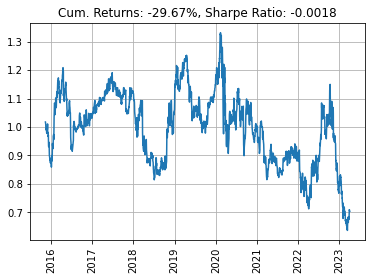

In [609]:
# plotting actual and predicted Adj Close price of random ticker
plt.plot(df.index, df['Return'], label='Actual Price % Change')
plt.plot(df.index, y_hat, label='Pred Price % Change')
plt.axvline(x=df.index[all_split], c='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('% Change')
plt.title(f'Train and Validation')
plt.legend()
plt.show()

print(f'Validation Performance Metrics with Indicators {indicators}')
print("MAE: ",round(MAE(df['Return'][all_split:], y_hat[all_split:]),4))
print("MSE: ",round(MSE(df['Return'][all_split:], y_hat[all_split:]),4))
print("RMSE: ",round(RMSE(df['Return'][all_split:], y_hat[all_split:]),4))

returns = np.where(y_hat[all_split:]>0,df['Return'][all_split:],
                   np.where(y_hat[all_split:]<0,-df['Return'][all_split:],np.nan))
returns = returns[~np.isnan(returns)]
cumreturns = np.cumprod(1+returns)

plt.plot(df.index[all_split:], cumreturns, label='Cum. Returns')
plt.title(f"Cum. Returns: {round((cumreturns[-1]-1)*100,2)}%, Sharpe Ratio: {round(returns.mean()/returns.std(),4)}")
plt.xticks(rotation=90)
plt.show()

## L1 Return

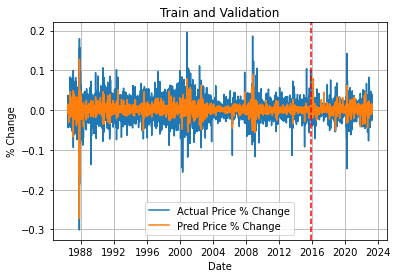

Validation Performance Metrics with Indicator 'Return_L1'
MAE:  0.013
MSE:  0.0004
RMSE:  0.019


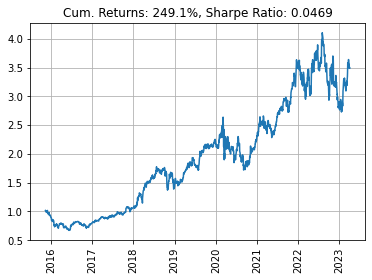

In [610]:
reg.fit(X_train[:,-1].reshape(-1,1), y_train, verbose=False)  # Change verbose to True if you want to see it train

# predicting response
y_hat = reg.predict(X_val[:,-1].reshape(-1,1))
val_set[:,-1] = y_hat
y_hat = scaler.inverse_transform(val_set)[:,-1] # inverse transformation

# plotting actual and predicted Adj Close price of random ticker
plt.plot(df.index, df['Return'], label='Actual Price % Change')
plt.plot(df.index, y_hat, label='Pred Price % Change')
plt.axvline(x=df.index[all_split], c='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('% Change')
plt.title(f'Train and Validation')
plt.legend()
plt.show()

print(f"Validation Performance Metrics with Indicator 'Return_L1'")
print("MAE: ",round(MAE(df['Return'][all_split:], y_hat[all_split:]),4))
print("MSE: ",round(MSE(df['Return'][all_split:], y_hat[all_split:]),4))
print("RMSE: ",round(RMSE(df['Return'][all_split:], y_hat[all_split:]),4))

returns = np.where(y_hat[all_split:]>0,df['Return'][all_split:],
                   np.where(y_hat[all_split:]<0,-df['Return'][all_split:],np.nan))
returns = returns[~np.isnan(returns)]
cumreturns = np.cumprod(1+returns)

plt.plot(df.index[all_split:], cumreturns, label='Cum. Returns')
plt.title(f"Cum. Returns: {round((cumreturns[-1]-1)*100,2)}%, Sharpe Ratio: {round(returns.mean()/returns.std(),4)}")
plt.xticks(rotation=90)
plt.show()

## Buy & Hold

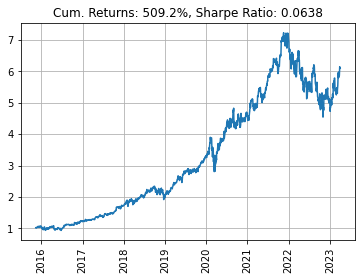

In [611]:
returns = df['Return'][all_split:]
returns = returns[~np.isnan(returns)]
cumreturns = np.cumprod(1+returns)

plt.plot(df.index[all_split:], cumreturns, label='Cum. Returns')
plt.title(f"Cum. Returns: {round((cumreturns[-1]-1)*100,2)}%, Sharpe Ratio: {round(returns.mean()/returns.std(),4)}")
plt.xticks(rotation=90)
plt.show()